Detected skew: 0.00° (to vertical)


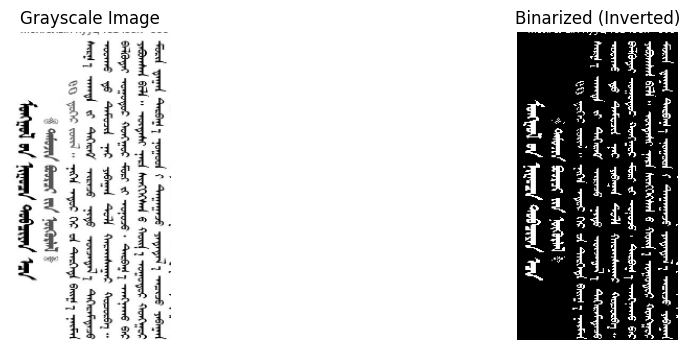

In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
from collections import deque
import segmenter as st

# Load image in grayscale
# image_path = 'data/test6.png'  # change this to your file path
# image_path = '../test_images/get_test1.jpg'  # change this to your file path
image_path = '../../../dataset/real_life/saihan_bichigten/adiya/processedv2/IMG_20250422_111558.png'  # change this to your file path
image_path = "data/surah_bichig.png"
gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
gray = st.estimate_vertical_skew_and_draw(gray)
# Binarize the image (invert to make text=1, background=0)
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

h, w = binary.shape

# Make a mask slightly larger than the image (required by floodFill)
mask = np.zeros((h + 2, w + 2), np.uint8)

# Flood fill from each corner
cv2.floodFill(binary, mask, (0, 0), 0)          
cv2.floodFill(binary, mask, (w - 1, 0), 0)      
cv2.floodFill(binary, mask, (0, h - 1), 0)     
cv2.floodFill(binary, mask, (w - 1, h - 1), 0) 

# Show the grayscale and binary images
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Grayscale Image")
plt.imshow(gray, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Binarized (Inverted)")
plt.imshow(binary, cmap='gray')
plt.axis('off')
plt.show()


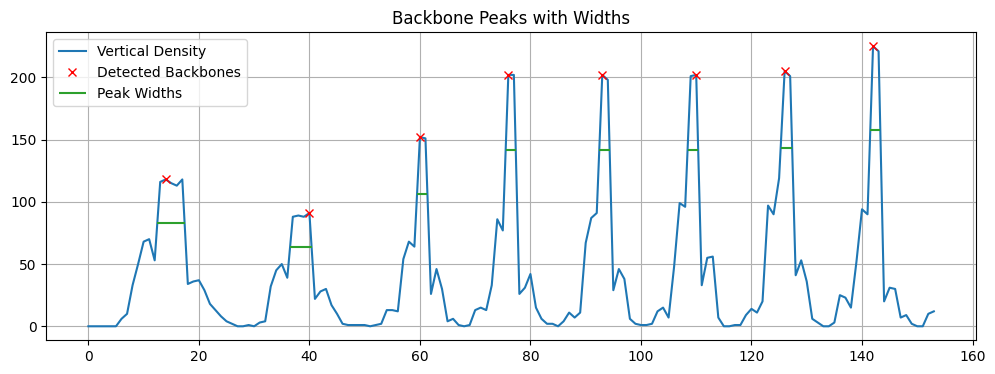

In [67]:
vertical_density = np.sum(binary > 0, axis=0)

# Detect peaks
peaks, _ = find_peaks(vertical_density, distance=10, prominence=20)

# Compute widths of the peaks
results_half = peak_widths(vertical_density, peaks, rel_height=0.3)
widths = results_half[0]  # Widths in number of pixels

# Visualize
plt.figure(figsize=(12, 4))
plt.plot(vertical_density, label='Vertical Density')
plt.plot(peaks, vertical_density[peaks], "rx", label='Detected Backbones')
plt.hlines(results_half[1], results_half[2], results_half[3], color="C2", label='Peak Widths')
plt.title("Backbone Peaks with Widths")
plt.legend()
plt.grid(True)
plt.show()

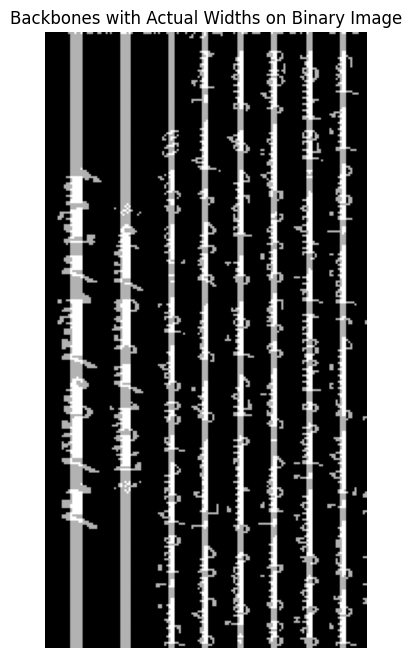

In [68]:
results_half = peak_widths(vertical_density, peaks, rel_height=0.3)
left_ips = results_half[2].astype(int)
right_ips = results_half[3].astype(int)

# Create blank image to draw backbones
backbone_mask = np.zeros_like(binary)

# Draw vertical lines based on actual peak width
for left, right in zip(left_ips, right_ips):
    backbone_mask[:, left:right + 1] = 255

# Visualize backbone lines on top of the binary image
combined = cv2.addWeighted(binary, 0.7, backbone_mask, 0.7, 0)

plt.figure(figsize=(6, 8))
plt.title("Backbones with Actual Widths on Binary Image")
plt.imshow(combined, cmap='gray')
plt.axis('off')
plt.show()

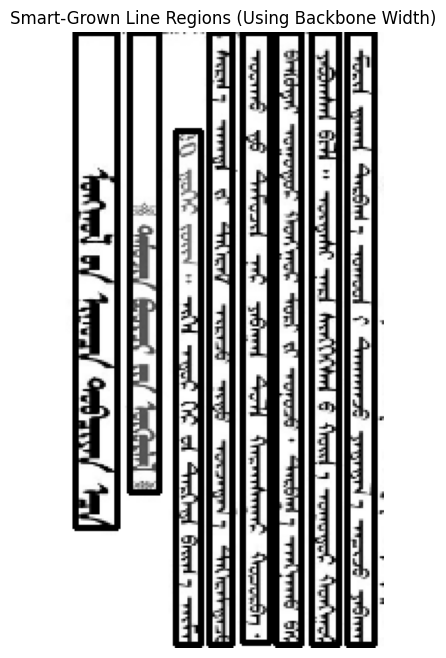

In [69]:
# Create blank image to draw regions
line_regions = np.zeros_like(binary)
height, width = binary.shape
visited = np.zeros_like(binary, dtype=bool)
line_bounding_boxes = []

def is_valid(y, x):
    return 0 <= x < width and 0 <= y < height and not visited[y, x] and binary[y, x] > 0

# Region growing for each backbone width
for left, right in zip(left_ips, right_ips):
    coords = []
    for x in range(left, right + 1):
        for y in range(height):
            if binary[y, x] > 0 and not visited[y, x]:
                queue = deque()
                queue.append((y, x))

                while queue:
                    cy, cx = queue.popleft()
                    if not is_valid(cy, cx):
                        continue
                    visited[cy, cx] = True
                    line_regions[cy, cx] = 255
                    coords.append((cy, cx))

                    for dy in [-1, 0, 1]:
                        for dx in [-1, 0, 1]:
                            ny, nx = cy + dy, cx + dx
                            if is_valid(ny, nx):
                                queue.append((ny, nx))

    if coords:
        ys, xs = zip(*coords)
        x_min, x_max = min(xs), max(xs)
        y_min, y_max = min(ys), max(ys)
        line_bounding_boxes.append((x_min, y_min, x_max, y_max))
output = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

for (x_min, y_min, x_max, y_max) in line_bounding_boxes:
    cv2.rectangle(output, (x_min, y_min), (x_max, y_max), (0, 0, 0), 2)
# Visualize the regions
plt.figure(figsize=(6, 8))
plt.title("Smart-Grown Line Regions (Using Backbone Width)")
plt.imshow(output, cmap='gray')
plt.axis('off')
plt.show()

In [70]:

def segment_words_from_line(gray, binary, line_bbox, overlap_threshold=0.3, adiya = False):
    """
    Segments words from a line image using connected components and merges nearby bounding boxes.
    
    Args:
        gray (np.ndarray): Grayscale version of the original image.
        binary (np.ndarray): Binary version of the image.
        line_bbox (tuple): Bounding box of the line (x_min, y_min, x_max, y_max).
        overlap_threshold (float): Threshold to merge overlapping word boxes.

    Returns:
        List[Tuple[int, int, int, int]]: List of word bounding boxes in original image coordinates.
    """
    line_x_min, line_y_min, line_x_max, line_y_max = line_bbox
    line_width = line_x_max - line_x_min

    line_piece = binary[line_y_min:line_y_max, line_x_min:line_x_max]
    binary_line = (line_piece > 0).astype(np.uint8)

    # Get connected components with stats
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_line)

    # Create a clean mask
    clean_mask = np.zeros_like(binary_line)

    # Minimum area threshold (tune as needed)
    min_area = 30  

    for i in range(1, num_labels):  # Skip background
        area = stats[i, cv2.CC_STAT_AREA]
        if area >= min_area:
            clean_mask[labels == i] = 255
    line_piece = clean_mask
    num_labels, labels = cv2.connectedComponents(line_piece)

    height, width = line_piece.shape
    expanded_bboxes = []

    for label in range(1, num_labels):
        y_coords, x_coords = np.where(labels == label)
        y_min, y_max = y_coords.min(), y_coords.max()
        x_min, x_max = x_coords.min(), x_coords.max()
        ratio =  (y_max - y_min) / (x_max - x_min) 
        if ratio > 0.5:
            expanded_bboxes.append((x_min, y_min, x_max, y_max))

    def get_overlap_area(box1, box2):
        x_min1, y_min1, x_max1, y_max1 = box1
        x_min2, y_min2, x_max2, y_max2 = box2

        overlap_x_min = max(x_min1, x_min2)
        overlap_x_max = min(x_max1, x_max2)
        overlap_y_min = max(y_min1, y_min2)
        overlap_y_max = min(y_max1, y_max2)

        if overlap_x_max > overlap_x_min and overlap_y_max > overlap_y_min:
            return (overlap_x_max - overlap_x_min) * (overlap_y_max - overlap_y_min)
        return 0

    merged_bboxes = []
    for box in expanded_bboxes:
        overlap_found = False
        for i, merged_box in enumerate(merged_bboxes):
            overlap_area = get_overlap_area(merged_box, box)
            box_area = (box[2] - box[0]) * (box[3] - box[1])

            if overlap_area / box_area > overlap_threshold:
                new_box = (
                    min(merged_box[0], box[0]),
                    min(merged_box[1], box[1]),
                    max(merged_box[2], box[2]),
                    max(merged_box[3], box[3]),
                )
                merged_bboxes[i] = new_box
                overlap_found = True
                break

        if not overlap_found:
            # Expand box horizontally to whole line if no overlap found
            box = (0, box[1], line_width, box[3])
            merged_bboxes.append(box)

    # Convert bboxes to original image coordinates
    word_bboxes_in_full_image = [
        (box[0] + line_x_min, box[1] + line_y_min, box[2] + line_x_min, box[3] + line_y_min)
        for box in merged_bboxes
    ]
    if adiya:
        
        min_height_ratio=1

        final_bboxes = []

        for i, box in enumerate(word_bboxes_in_full_image):
            box_height = box[3] - box[1]
            box_width = box[2] - box[0]
            
            # Merge with the previous box if height < 2*width
            if i > 0 and box_height < min_height_ratio * box_width:
                prev_box = final_bboxes[-1]
                new_box = (
                    min(prev_box[0], box[0]),
                    min(prev_box[1], box[1]),
                    max(prev_box[2], box[2]),
                    max(prev_box[3], box[3]),
                )
                final_bboxes[-1] = new_box
            else:
                final_bboxes.append(box)
            
            return final_bboxes

    return word_bboxes_in_full_image


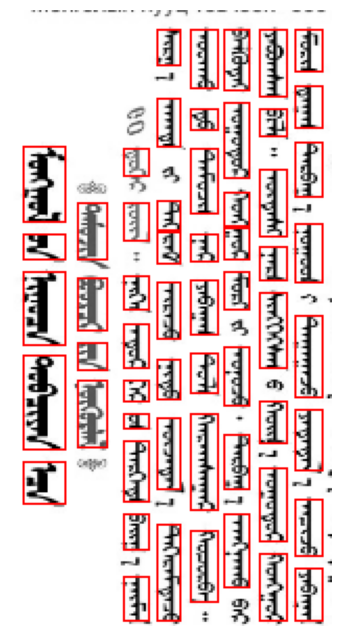

In [71]:
output = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

all_word_bboxes = []

for line_bbox in line_bounding_boxes:
    words = segment_words_from_line(gray, binary, line_bbox, adiya=False)
    all_word_bboxes.extend(words)

# Draw all word bounding boxes
for (x_min, y_min, x_max, y_max) in all_word_bboxes:
    cv2.rectangle(output, (x_min, y_min), (x_max, y_max), (255, 0, 0), 1)

plt.figure(figsize=(6, 8))

plt.imshow(output, cmap='gray')
plt.axis('off')
plt.show()

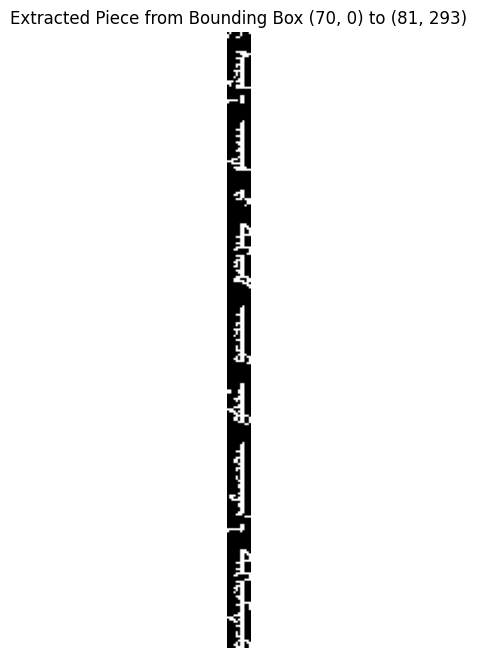

In [77]:
line_x_min, line_y_min, line_x_max, line_y_max = line_bounding_boxes[3]

line_width = line_x_max - line_x_min

# Extract the line region from the binary image
line_orig = gray[line_y_min:line_y_max, line_x_min:line_x_max]
line_piece = binary[line_y_min:line_y_max, line_x_min:line_x_max]

# Show the extracted piece
plt.figure(figsize=(6, 8))
plt.title(f"Extracted Piece from Bounding Box ({line_x_min}, {line_y_min}) to ({line_x_max}, {line_y_max})")
plt.imshow(line_piece, cmap='gray')
plt.axis('off')
plt.show()

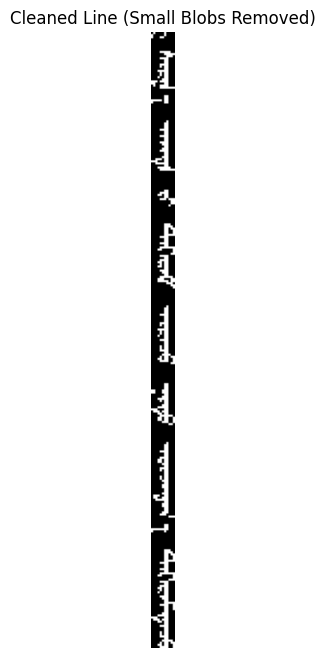

In [78]:
binary_line = (line_piece > 0).astype(np.uint8)

# Get connected components with stats
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_line)

# Create a clean mask
clean_mask = np.zeros_like(binary_line)

# Minimum area threshold (tune as needed)
min_area = 3

for i in range(1, num_labels):  # Skip background
    area = stats[i, cv2.CC_STAT_AREA]
    if area >= min_area:
        clean_mask[labels == i] = 255

# Optional: visualize cleaned region
plt.figure(figsize=(6, 8))
plt.title("Cleaned Line (Small Blobs Removed)")
plt.imshow(clean_mask, cmap='gray')
plt.axis('off')
plt.show()

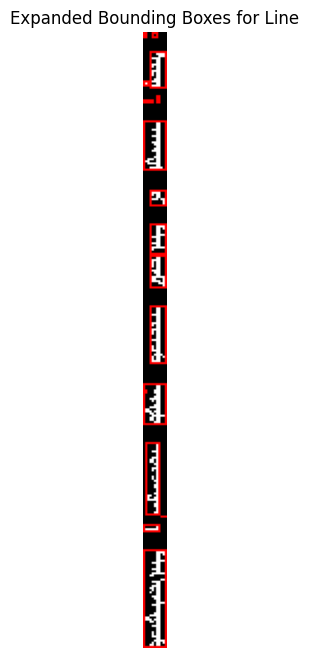

In [94]:
line_piece = clean_mask
# line_regions = np.zeros_like(line_piece)
merged_image = cv2.cvtColor(line_piece, cv2.COLOR_GRAY2BGR)
# Use connected components to detect the different parts of the line
num_labels, labels = cv2.connectedComponents(line_piece)

word_regions = cv2.cvtColor(line_piece, cv2.COLOR_GRAY2BGR)
# Now, expand each component (neighbor-wise)
expanded_bboxes = []
height, width = line_piece.shape

for label in range(1, num_labels):  # Start from 1 to avoid the background label (0)
    # Find the coordinates of the current component
    y_coords, x_coords = np.where(labels == label)
    y_min, y_max = y_coords.min(), y_coords.max()
    x_min, x_max = x_coords.min(), x_coords.max()
    ratio = (y_max - y_min) / ( x_max - x_min )
    # Expand the box based on neighbors
    # if ratio >= 0.1 :
    #     expanded_bboxes.append((x_min, y_min, x_max, y_max))
    expanded_bboxes.append((x_min, y_min, x_max, y_max))

    # Draw the bounding box on the image for visualization
    cv2.rectangle(word_regions, (x_min, y_min), (x_max, y_max), 255, 1)

# Show the expanded bounding boxes for visualization
plt.figure(figsize=(6, 8))
plt.title("Expanded Bounding Boxes for Line")
plt.imshow(word_regions, cmap='gray')
plt.axis('off')
plt.show()

C:\Users\home\AppData\Local\Temp\ipykernel_14684\488121961.py:28: RuntimeWarning: invalid value encountered in scalar divide
  if overlap_area / box_area > overlap_threshold:


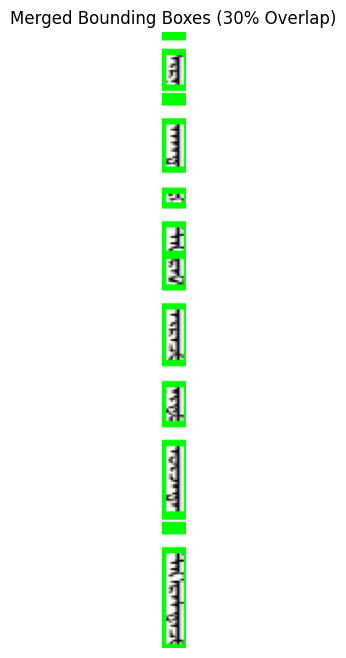

In [95]:
overlap_threshold=0.3

# Function to calculate the intersection area between two boxes
def get_overlap_area(box1, box2):
    x_min1, y_min1, x_max1, y_max1 = box1
    x_min2, y_min2, x_max2, y_max2 = box2

    # Calculate the intersection area
    overlap_x_min = max(x_min1, x_min2)
    overlap_x_max = min(x_max1, x_max2)
    overlap_y_min = max(y_min1, y_min2)
    overlap_y_max = min(y_max1, y_max2)

    if overlap_x_max > overlap_x_min and overlap_y_max > overlap_y_min:
        overlap_area = (overlap_x_max - overlap_x_min) * (overlap_y_max - overlap_y_min)
        return overlap_area
    return 0

# Merge boxes if 80% overlap
merged_bboxes = []

for box in expanded_bboxes:
    overlap_found = False
    for merged_box in merged_bboxes:
        overlap_area = get_overlap_area(merged_box, box)
        box_area = (box[2] - box[0]) * (box[3] - box[1])
        
        if overlap_area / box_area > overlap_threshold:
            # Merge the boxes by taking the min and max of the coordinates
            new_box = (
                min(merged_box[0], box[0]),
                min(merged_box[1], box[1]),
                max(merged_box[2], box[2]),
                max(merged_box[3], box[3]),
            )
            merged_bboxes.remove(merged_box)
            merged_bboxes.append(new_box)
            overlap_found = True
            break
    
    if not overlap_found:
        box = 0, box[1], line_width, box[3]
        merged_bboxes.append(box)

# Show the merged bounding boxes
merged_image = cv2.cvtColor(line_orig, cv2.COLOR_GRAY2BGR)
for bbox in merged_bboxes:
    cv2.rectangle(merged_image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)

plt.figure(figsize=(6, 8))
plt.title("Merged Bounding Boxes (30% Overlap)")
plt.imshow(merged_image[..., ::-1])  # BGR to RGB
plt.axis('off')
plt.show()


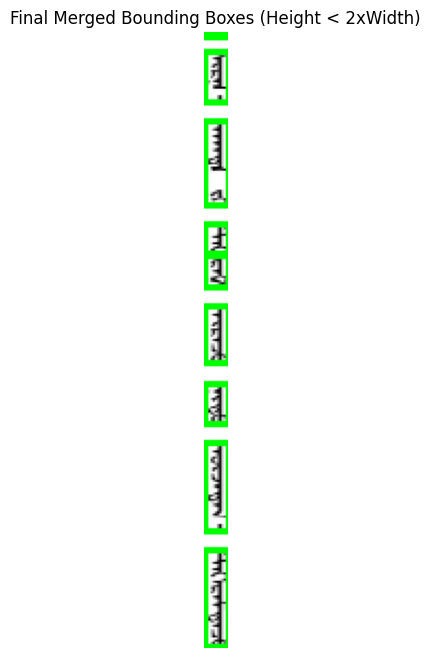

Individual bounding boxes:


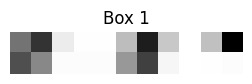

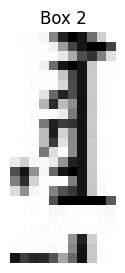

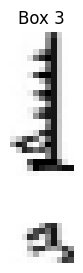

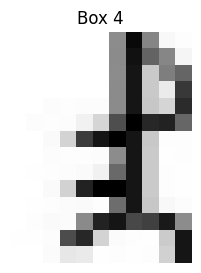

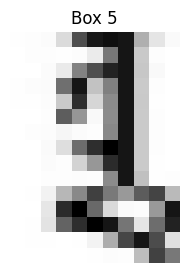

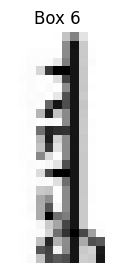

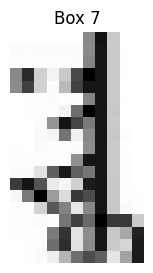

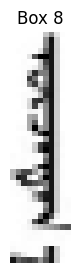

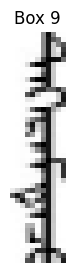

In [96]:
# Check if the height is smaller than twice the width and merge with the top box if necessary
min_height_ratio=1

final_bboxes = []

for i, box in enumerate(merged_bboxes):
    box_height = box[3] - box[1]
    box_width = box[2] - box[0]
    
    # Merge with the previous box if height < 2*width
    if i > 0 and box_height < min_height_ratio * box_width:
        prev_box = final_bboxes[-1]
        new_box = (
            min(prev_box[0], box[0]),
            min(prev_box[1], box[1]),
            max(prev_box[2], box[2]),
            max(prev_box[3], box[3]),
        )
        final_bboxes[-1] = new_box
    else:
        final_bboxes.append(box)

# Show the final merged boxes
final_image = cv2.cvtColor(line_orig, cv2.COLOR_GRAY2BGR)
for bbox in final_bboxes:
    cv2.rectangle(final_image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)

# Show the main image with all final bounding boxes
plt.figure(figsize=(6, 8))
plt.title("Final Merged Bounding Boxes (Height < 2xWidth)")
plt.imshow(final_image[..., ::-1])  # BGR to RGB
plt.axis('off')
plt.show()

# Show each bounding box as a separate image
print("Individual bounding boxes:")
for i, bbox in enumerate(final_bboxes):
    x1, y1, x2, y2 = bbox
    cropped = line_orig[y1:y2, x1:x2]
    
    plt.figure(figsize=(3, 3))
    plt.title(f"Box {i+1}")
    plt.imshow(cropped, cmap='gray')
    plt.axis('off')
    plt.show()

